# Analyzing perturbation simulation results on pancreatic endocrine dataset

Notebook for analyzing and visulizing RegVelo's perturbation results

## Library imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc, roc_curve

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import scanpy as sc
import scvelo as scv

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.perturbation import aggregate_model_predictions

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [4]:
DATASET = "pancreatic_endocrinogenesis"

In [5]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [6]:
TERMINAL_STATES = ["Alpha", "Beta", "Delta", "Epsilon"]

## Function defination

In [7]:
def min_max_scaling(data):
    """Apply min-max scaling to a numpy array or pandas Series.

    Parameters
    ----------
    data (np.ndarray or pd.Series): The input data to be scaled.

    Returns
    -------
    np.ndarray or pd.Series: Scaled data with values between 0 and 1.
    """
    min_val = np.min(data)
    max_val = np.max(data)

    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data

## Data loading

In [8]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")

In [9]:
regvelo_prediction = aggregate_model_predictions(DATA_DIR / DATASET / "results")

In [10]:
palette = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))

## Drivers prediction

In [11]:
driver_list = {
    "Alpha": ["Pou6f2", "Irx1", "Irx2", "Smarca1"],
    "Delta": ["Hhex"],
    "Beta": ["Pdx1", "Glis3", "Mafa", "Mafb"],
    "Epsilon": ["Arg4", "Nuak2", "Tead1"],
}

In [12]:
score = (
    min_max_scaling(-regvelo_prediction[0].loc[:, "Alpha"]).tolist()
    + min_max_scaling(-regvelo_prediction[0].loc[:, "Beta"]).tolist()
    + min_max_scaling(-regvelo_prediction[0].loc[:, "Delta"]).tolist()
    + min_max_scaling(-regvelo_prediction[0].loc[:, "Epsilon"]).tolist()
)


label = (
    [1 if i in driver_list["Alpha"] else 0 for i in regvelo_prediction[0].index.tolist()]
    + [1 if i in driver_list["Beta"] else 0 for i in regvelo_prediction[0].index.tolist()]
    + [1 if i in driver_list["Delta"] else 0 for i in regvelo_prediction[0].index.tolist()]
    + [1 if i in driver_list["Epsilon"] else 0 for i in regvelo_prediction[0].index.tolist()]
)

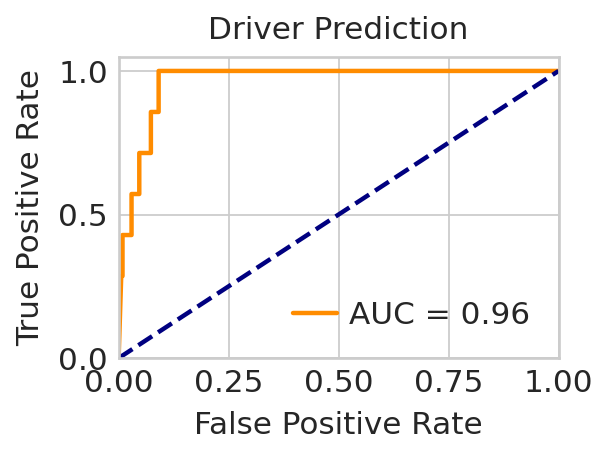

In [13]:
with mplscience.style_context():  # Entering the custom style context
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)
    sns.set_style("whitegrid")
    # Create a figure and axis object with a specified size
    fig, ax = plt.subplots(figsize=(4, 3))

    # Plot ROC curve
    ax.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.2f}")

    # Plot diagonal line (random guess line)
    ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    # Set limits for x and y axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    # Set labels, title, and ticks with specified font sizes
    ax.set_xlabel("False Positive Rate", fontsize=14)
    ax.set_ylabel("True Positive Rate", fontsize=14)
    ax.set_title("Driver Prediction", fontsize=14)
    ax.tick_params(axis="both", which="major", labelsize=14)

    # Add legend
    ax.legend(loc="lower right", fontsize=14)
    # Adjust layout to fit the elements within the figure area
    plt.tight_layout()
    # Save figure if SAVE_FIGURES is True
    if SAVE_FIGURES:
        save_path = FIG_DIR / DATASET / "ROC_curve.svg"
        fig.savefig(save_path, format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## Visualize Neurod2 perturbation

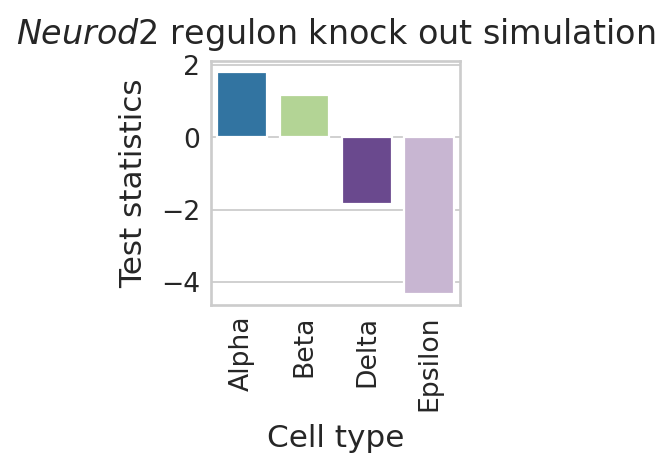

In [14]:
color_label = "cell_type"
df = pd.DataFrame(regvelo_prediction[0].loc["Neurod2", :])
df.columns = ["Test statistics"]
df["Cell type"] = regvelo_prediction[0].columns.tolist()
order = TERMINAL_STATES

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.barplot(
        data=df,
        y="Test statistics",
        x="Cell type",
        palette=palette,
        order=order,
        ax=ax,
    )
    # ax.set(ylim=(-0.05, 0.05))
    ax.tick_params(axis="x", rotation=90)
    plt.title("$\\mathit{" + "Neurod2" + "}$ regulon knock out simulation")

    if SAVE_FIGURES:
        plt.savefig(
            FIG_DIR / DATASET / "Neurod2_perturbation_simulation.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )
    # Show the plot
    plt.show()

## Load original perturbation prediction results to reproduce results in manuscript

### Benchmark perturbation effect estimation robustness

In [15]:
regvelo_prediction_all = aggregate_model_predictions(
    DATA_DIR / DATASET / "raw" / "TF_perturbation", method="t-statistics"
)

In [16]:
for i in range(len(regvelo_prediction_all)):
    regvelo_prediction_all[i].columns = regvelo_prediction_all[i].columns + f"_{i}"

In [17]:
rgv_p_all = pd.concat(regvelo_prediction_all, axis=1)

correlation_results = {}
for fate in TERMINAL_STATES:
    fate_cols = [f"{fate}_{i}" for i in range(5)]
    fate_df = rgv_p_all[fate_cols]
    correlation_results[f"{fate}"] = fate_df.corr()

In [18]:
corr_all = []
for fate in TERMINAL_STATES:  # Assuming there are 4 metrics
    correlation_matrix = correlation_results[f"{fate}"]
    corr_pairwise = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    corr_all = corr_all + corr_pairwise.stack().tolist()

df = pd.DataFrame({"Correlation": corr_all, "Group": np.repeat(TERMINAL_STATES, len(corr_pairwise.stack().tolist()))})

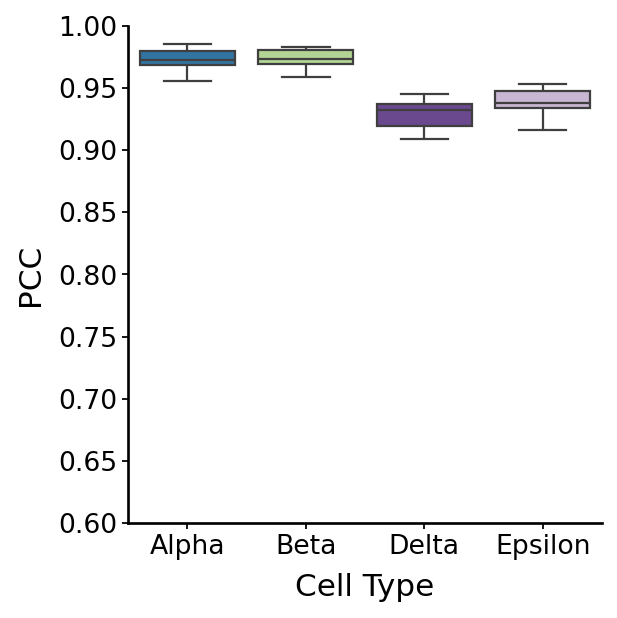

In [19]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 4))

    sns.boxplot(data=df, x="Group", y="Correlation", palette=palette, ax=ax)

    plt.xlabel("Cell Type")
    plt.ylabel("PCC")
    plt.ylim(0.6, 1)
    plt.tight_layout()
    plt.show()

### Visualize Neurod2 perturbation effects

In [20]:
regvelo_prediction_all = aggregate_model_predictions(
    DATA_DIR / DATASET / "raw" / "TF_perturbation", method="t-statistics"
)

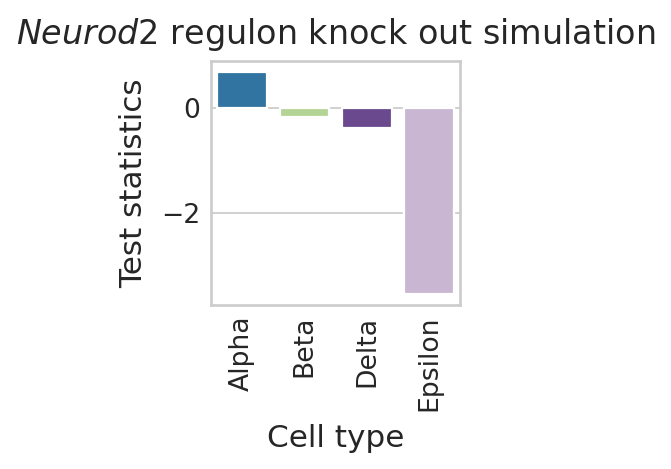

In [21]:
color_label = "cell_type"
df = pd.DataFrame(regvelo_prediction_all[0].loc["Neurod2", :])
df.columns = ["Test statistics"]
df["Cell type"] = regvelo_prediction_all[0].columns.tolist()
order = TERMINAL_STATES

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.barplot(
        data=df,
        y="Test statistics",
        x="Cell type",
        palette=palette,
        order=order,
        ax=ax,
    )

    ax.tick_params(axis="x", rotation=90)
    plt.title("$\\mathit{" + "Neurod2" + "}$ regulon knock out simulation")

    if SAVE_FIGURES:
        plt.savefig(
            FIG_DIR / DATASET / "Neurod2_perturbation_simulation.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )
    # Show the plot
    plt.show()

## Load target screening results for Neurod2

In [22]:
Neurod2_target_perturbation = aggregate_model_predictions(
    DATA_DIR / DATASET / "raw" / "Neurod2_perturbation", method="t-statistics"
)

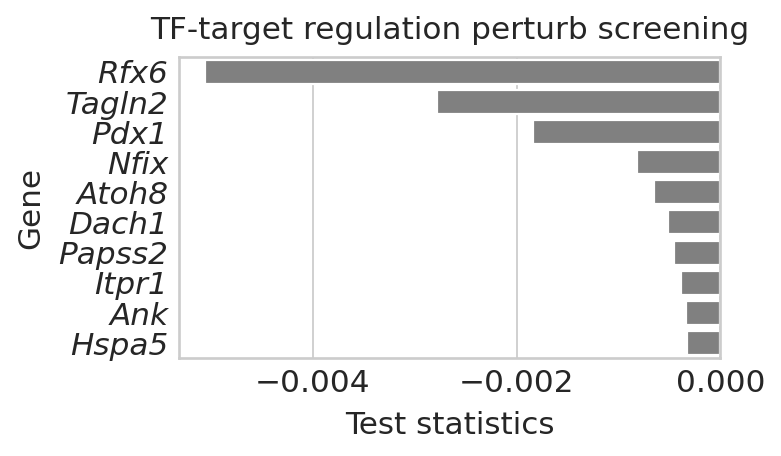

In [23]:
## rank the Epsilon prediction results
with mplscience.style_context():  # Entering the custom style context
    sns.set_style("whitegrid")
    gene_scores = pd.DataFrame(
        {
            "Gene": Neurod2_target_perturbation[0].index.tolist(),
            "Score": Neurod2_target_perturbation[0].loc[:, "Epsilon"],
        }
    )
    gene_scores.loc[:, "weights"] = gene_scores.loc[:, "Score"].abs()
    # gene_scores = gene_scores.sort_values(by='weights', ascending=False).iloc[:10,:]
    gene_scores = gene_scores.sort_values(by="Score", ascending=True).iloc[:10, :]
    # Create the horizontal bar plot using Seaborn
    plt.figure(figsize=(5, 3))  # Set the figure size
    g = sns.barplot(x="Score", y="Gene", data=gene_scores, color="grey")

    # Customize plot aesthetics
    g.set_ylabel("Gene", fontsize=14)
    g.set_xlabel("Test statistics", fontsize=14)

    # Customize tick parameters for better readability
    g.tick_params(axis="x", labelsize=14)
    g.tick_params(axis="y", labelsize=14)
    g.set_title("TF-target regulation perturb screening", fontsize=14)

    plt.tight_layout()
    plt.setp(g.get_yticklabels(), fontstyle="italic")

    if SAVE_FIGURES:
        save_path = FIG_DIR / DATASET / "Neurod2_target_screening.svg"
        fig.savefig(save_path, format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## Predict Rfx6 perturbation effects

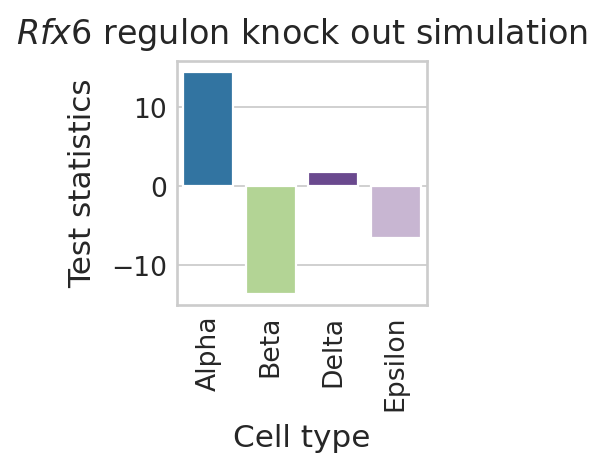

In [24]:
color_label = "cell_type"
df = pd.DataFrame(regvelo_prediction_all[0].loc["Rfx6", :])
df.columns = ["Test statistics"]
df["Cell type"] = regvelo_prediction_all[0].columns.tolist()
order = TERMINAL_STATES

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.barplot(
        data=df,
        y="Test statistics",
        x="Cell type",
        palette=palette,
        order=order,
        ax=ax,
    )
    # ax.set(ylim=(-0.05, 0.05))
    ax.tick_params(axis="x", rotation=90)
    plt.title("$\\mathit{" + "Rfx6" + "}$ regulon knock out simulation")

    if SAVE_FIGURES:
        plt.savefig(
            FIG_DIR / DATASET / "Rfx6_perturbation_simulation.svg", format="svg", transparent=True, bbox_inches="tight"
        )
    # Show the plot
    plt.show()